In [1]:
import requests
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
set_config(display='diagram') # Để trực quan hóa pipeline

In [2]:
# Hàm thu thập dữ liệu từ một khoảng thời gian cụ thể
def collect_data(api_url):
    weather_data = []
    success = False
    while not success:
        print(f"GET: {api_url}")
        r = requests.get(api_url)
        if r.ok:
            # lấy kết quả json
            pydata = json.loads(r.text)
            weather_data.extend(pydata["days"])  # Lưu dữ liệu từ 'days'
            print("Successful! Remaining cost:", pydata.get('remainingCost', 'Unknown'))
            print()
            success = True
        else:
            print("Fail! Try again. Status code:", r.status_code)
            time.sleep(5)
        
    return weather_data


In [3]:
# Hàm tạo URL API từ các tham số đầu vào
def create_api_url(location, start_date, end_date, api_key, unit_group='metric', include='days'):
    return f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}?unitGroup={unit_group}&include={include}&key={api_key}&contentType=json'

# Hàm thu thập dữ liệu trong khoảng thời gian từ nhiều năm
def collect_all_data(start_date, end_date, location, api_key):
    # Tạo URL API
    api_url = create_api_url(location, start_date, end_date, api_key)
    # Thu thập dữ liệu thời tiết
    weather_data = collect_data(api_url)
    
    return weather_data

In [4]:
# API key (có thể thay đổi)
api_key1 = 'TE7HPVTQ4Q4B7LWSLDSU38BRF'
api_key2 = "VNTCFNZ5VLGZC3FW4F85U8425"
api_key3 = "VWAK37JBEPXKWXTP7U8MQG9FR"

# Thông số đầu vào (có thể thay đổi)
location = 'hanoi'
start_date = '2022-09-01'
end_date = '2024-09-01'

In [5]:
# # Thu thập dữ liệu
# all_weather_data = collect_all_data(start_date, end_date, location, api_key3)

# # In số lượng dữ liệu thu thập được
# print('Number of data:', len(all_weather_data))

# # Lưu dữ liệu vào DataFrame và xuất ra CSV
# data_df = pd.DataFrame(all_weather_data)
# data_df.rename(lambda name: name[0].upper() + name[1:], axis='columns', inplace=True)
# data_df.to_csv('historical_weather_data.csv', index=False)

# # Hiển thị 5 dòng đầu tiên của dữ liệu
# data_df.head()

In [6]:
# Đọc dữ liệu từ file CSV
csv_file_path = 'historical_weather_data.csv'  # Đường dẫn đến file CSV
all_weather_data = pd.read_csv(csv_file_path)

# In số lượng dữ liệu đã tải về
print('Number of data loaded from CSV:', len(all_weather_data))


Number of data loaded from CSV: 732


In [7]:
# Kiểm tra kiểu dữ liệu của các cột
print(all_weather_data.dtypes)

Datetime           object
DatetimeEpoch       int64
Tempmax           float64
Tempmin           float64
Temp              float64
Feelslikemax      float64
Feelslikemin      float64
Feelslike         float64
Dew               float64
Humidity          float64
Precip            float64
Precipprob        float64
Precipcover       float64
Preciptype         object
Snow              float64
Snowdepth         float64
Windgust          float64
Windspeed         float64
Winddir           float64
Pressure          float64
Cloudcover        float64
Visibility        float64
Solarradiation    float64
Solarenergy       float64
Uvindex           float64
Severerisk        float64
Sunrise            object
SunriseEpoch        int64
Sunset             object
SunsetEpoch         int64
Moonphase         float64
Conditions         object
Description        object
Icon               object
Stations           object
Source             object
dtype: object


In [8]:
# Kiểm tra số lượng giá trị không bị thiếu trong mỗi cột
non_null_counts = all_weather_data.count()

# Tính tỷ lệ phần trăm giá trị thiếu trong mỗi cột
missing_percentage = all_weather_data.isnull().mean() * 100

# Tạo DataFrame từ non-null counts và missing percentage
summary_df = pd.DataFrame({
    'Column Name': all_weather_data.columns,
    'Non-null Count': all_weather_data.count().values,
    'Missing Percentage': all_weather_data.isnull().mean().values * 100
})

# In bảng
print(summary_df)

# Lọc ra các cột có tỷ lệ dữ liệu thiếu lớn hơn 20%
missing_columns = missing_percentage[missing_percentage > 20]
print("\nColumns with more than 20% missing data:")
print(missing_columns)

# Tìm các cột có ít hơn 50 giá trị không bị thiếu
low_data_columns = non_null_counts[non_null_counts < 50]
print("\nColumns with less than 50 non-null values:")
print(low_data_columns)

       Column Name  Non-null Count  Missing Percentage
0         Datetime             732             0.00000
1    DatetimeEpoch             732             0.00000
2          Tempmax             732             0.00000
3          Tempmin             732             0.00000
4             Temp             732             0.00000
5     Feelslikemax             732             0.00000
6     Feelslikemin             732             0.00000
7        Feelslike             732             0.00000
8              Dew             732             0.00000
9         Humidity             732             0.00000
10          Precip             732             0.00000
11      Precipprob             732             0.00000
12     Precipcover             732             0.00000
13      Preciptype             544            25.68306
14            Snow             732             0.00000
15       Snowdepth             732             0.00000
16        Windgust             732             0.00000
17       W

In [9]:
# In ra thông tin dữ liệu số cột trước khi loại bỏ
print("Columns before dropping 'Preciptype':")
print(all_weather_data.columns)

# In số lượng cột trước khi loại bỏ
print("Number of columns before dropping 'Preciptype':", len(all_weather_data.columns))

# Loại bỏ cột 'Preciptype' khỏi DataFrame
all_weather_data = all_weather_data.drop(columns=['Preciptype'])

# In ra thông tin dữ liệu sau khi loại bỏ cột
print("Columns after dropping 'Preciptype':")
print(all_weather_data.columns)

# In số lượng cột sau khi loại bỏ
print("Number of columns after dropping 'Preciptype':", len(all_weather_data.columns))

Columns before dropping 'Preciptype':
Index(['Datetime', 'DatetimeEpoch', 'Tempmax', 'Tempmin', 'Temp',
       'Feelslikemax', 'Feelslikemin', 'Feelslike', 'Dew', 'Humidity',
       'Precip', 'Precipprob', 'Precipcover', 'Preciptype', 'Snow',
       'Snowdepth', 'Windgust', 'Windspeed', 'Winddir', 'Pressure',
       'Cloudcover', 'Visibility', 'Solarradiation', 'Solarenergy', 'Uvindex',
       'Severerisk', 'Sunrise', 'SunriseEpoch', 'Sunset', 'SunsetEpoch',
       'Moonphase', 'Conditions', 'Description', 'Icon', 'Stations', 'Source'],
      dtype='object')
Number of columns before dropping 'Preciptype': 36
Columns after dropping 'Preciptype':
Index(['Datetime', 'DatetimeEpoch', 'Tempmax', 'Tempmin', 'Temp',
       'Feelslikemax', 'Feelslikemin', 'Feelslike', 'Dew', 'Humidity',
       'Precip', 'Precipprob', 'Precipcover', 'Snow', 'Snowdepth', 'Windgust',
       'Windspeed', 'Winddir', 'Pressure', 'Cloudcover', 'Visibility',
       'Solarradiation', 'Solarenergy', 'Uvindex', 'Severeri

In [10]:
# Đường dẫn đến file CSV mới
new_csv_file_path = 'cleaned_historical_weather_data.csv'  

# Lưu DataFrame vào file CSV
all_weather_data.to_csv(new_csv_file_path, index=False)

# Xác nhận rằng dữ liệu đã được lưu
print(f"Data has been saved to {new_csv_file_path}.")


Data has been saved to cleaned_historical_weather_data.csv.


In [11]:
# Nhập các thư viện cần thiết
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Tiền xử lý dữ liệu
# Chuyển đổi cột 'Datetime' thành định dạng datetime
all_weather_data['Datetime'] = pd.to_datetime(all_weather_data['Datetime'])

# Chọn các cột đặc trưng và nhãn
X = all_weather_data[['Tempmax', 'Tempmin', 'Feelslikemax', 'Feelslikemin', 
                      'Dew', 'Pressure', 'Cloudcover', 'Visibility', 'Solarradiation']]
y_temp = all_weather_data['Temp']  # Nhãn cho dự đoán nhiệt độ
y_humidity = all_weather_data['Humidity']  # Nhãn cho dự đoán độ ẩm

# Tách dữ liệu thành tập huấn luyện và kiểm tra (80-20)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)
_, _, y_train_humidity, y_test_humidity = train_test_split(X, y_humidity, test_size=0.2, random_state=42)

# 2. Xây dựng mô hình hồi quy tuyến tính
linear_reg_temp = LinearRegression()
linear_reg_humidity = LinearRegression()

# 3. Huấn luyện mô hình
linear_reg_temp.fit(X_train, y_train_temp)
linear_reg_humidity.fit(X_train, y_train_humidity)

# 4. Dự đoán
# Dự đoán nhiệt độ
y_pred_temp = linear_reg_temp.predict(X_test)
# Dự đoán độ ẩm
y_pred_humidity = linear_reg_humidity.predict(X_test)

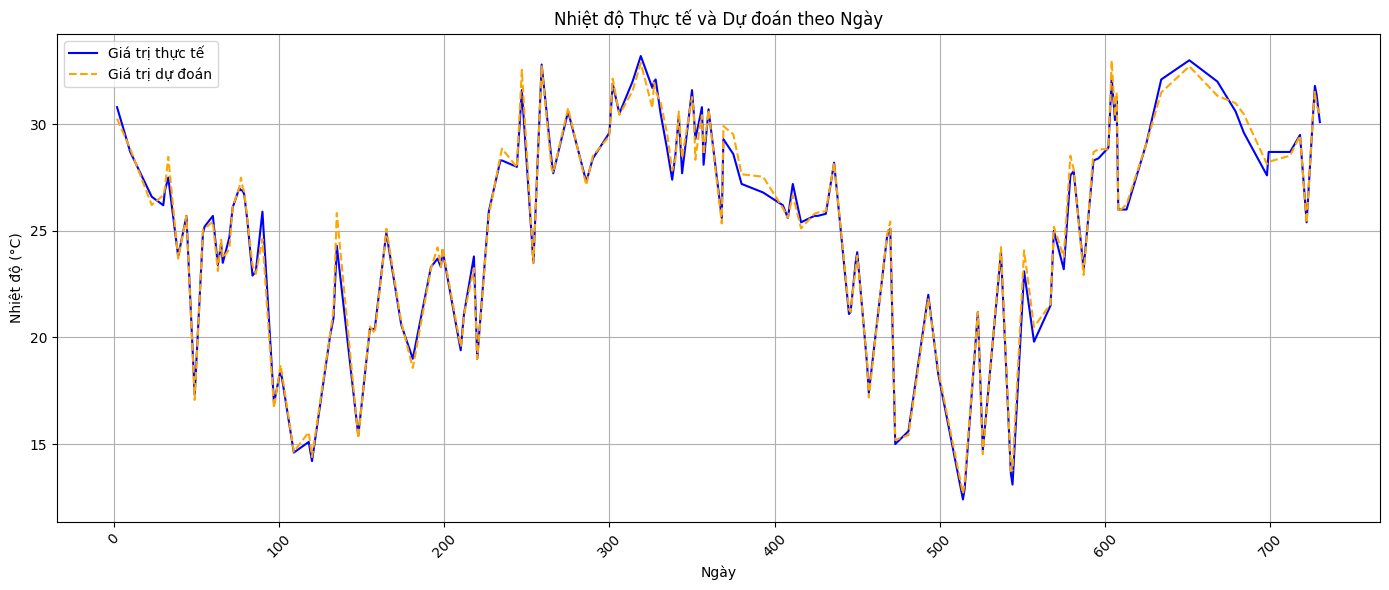

In [12]:
# Chuyển đổi chỉ số của DataFrame thành cột 'Datetime' để sử dụng cho trục x
y_test_temp = pd.Series(y_test_temp, index=X_test.index)
y_pred_temp = pd.Series(y_pred_temp, index=X_test.index)

# Tạo biểu đồ nhiệt độ
plt.figure(figsize=(14, 6))
sns.lineplot(data=y_test_temp, label='Giá trị thực tế', color='blue')
sns.lineplot(data=y_pred_temp, label='Giá trị dự đoán', color='orange', linestyle='--')

# Định dạng trục x
plt.xticks(rotation=45)
plt.title('Nhiệt độ Thực tế và Dự đoán theo Ngày')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


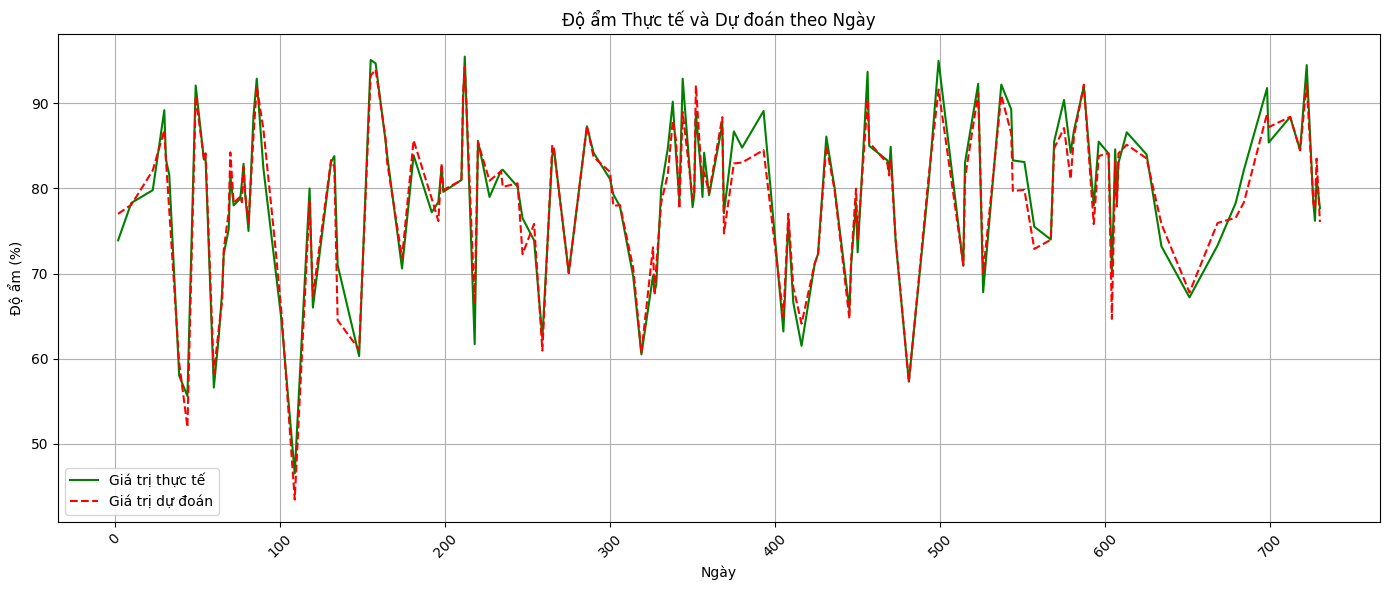

In [13]:
# Chuyển đổi chỉ số của DataFrame thành cột 'Datetime' cho độ ẩm
y_test_humidity = pd.Series(y_test_humidity, index=X_test.index)
y_pred_humidity = pd.Series(y_pred_humidity, index=X_test.index)

# Tạo biểu đồ độ ẩm
plt.figure(figsize=(14, 6))
sns.lineplot(data=y_test_humidity, label='Giá trị thực tế', color='green')
sns.lineplot(data=y_pred_humidity, label='Giá trị dự đoán', color='red', linestyle='--')

# Định dạng trục x
plt.xticks(rotation=45)
plt.title('Độ ẩm Thực tế và Dự đoán theo Ngày')
plt.xlabel('Ngày')
plt.ylabel('Độ ẩm (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [14]:
# Đánh giá mô hình cho nhiệt độ
print("Temperature Prediction Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test_temp, y_pred_temp))
print("Mean Squared Error:", mean_squared_error(y_test_temp, y_pred_temp))
print("R-squared:", r2_score(y_test_temp, y_pred_temp))

# Đánh giá mô hình cho độ ẩm
print("\nHumidity Prediction Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test_humidity, y_pred_humidity))
print("Mean Squared Error:", mean_squared_error(y_test_humidity, y_pred_humidity))
print("R-squared:", r2_score(y_test_humidity, y_pred_humidity))


Temperature Prediction Metrics:
Mean Absolute Error: 0.3043554309378012
Mean Squared Error: 0.17029853650344234
R-squared: 0.9929529594308159

Humidity Prediction Metrics:
Mean Absolute Error: 1.53617029440791
Mean Squared Error: 3.995610680517618
R-squared: 0.9533800059115431
